In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import textwrap

In [47]:
with open("output/baseline_mistral_large_100_chunksize256.jsonl") as f:
    lines = f.readlines()
    baseline_outputs = [json.loads(line) for line in lines]

with open("output/summarization_with_corresponding_in_context_mistral_large_chunksize256.jsonl") as f:
    lines = f.readlines()
    summarization_outputs = [json.loads(line) for line in lines]

with open("output/summary_union_with_corresponding_in_context_mistral_large_chunksize256.jsonl") as f:
    lines = f.readlines()
    s_plus_outputs = [json.loads(line) for line in lines]

with open("output/question_generation_with_corresponding_in_context_mistral_large_chunksize256.jsonl") as f:
    lines = f.readlines()
    question_generation_outputs = [json.loads(line) for line in lines]

with open("output/question_union_with_corresponding_in_context_mistral_large_chunksize256.jsonl") as f:
    lines = f.readlines()
    q_plus_outputs = [json.loads(line) for line in lines]

with open("output/union_with_corresponding_in_context_mistral_large_chunksize256.jsonl") as f:
    lines = f.readlines()
    union_outputs = [json.loads(line) for line in lines]

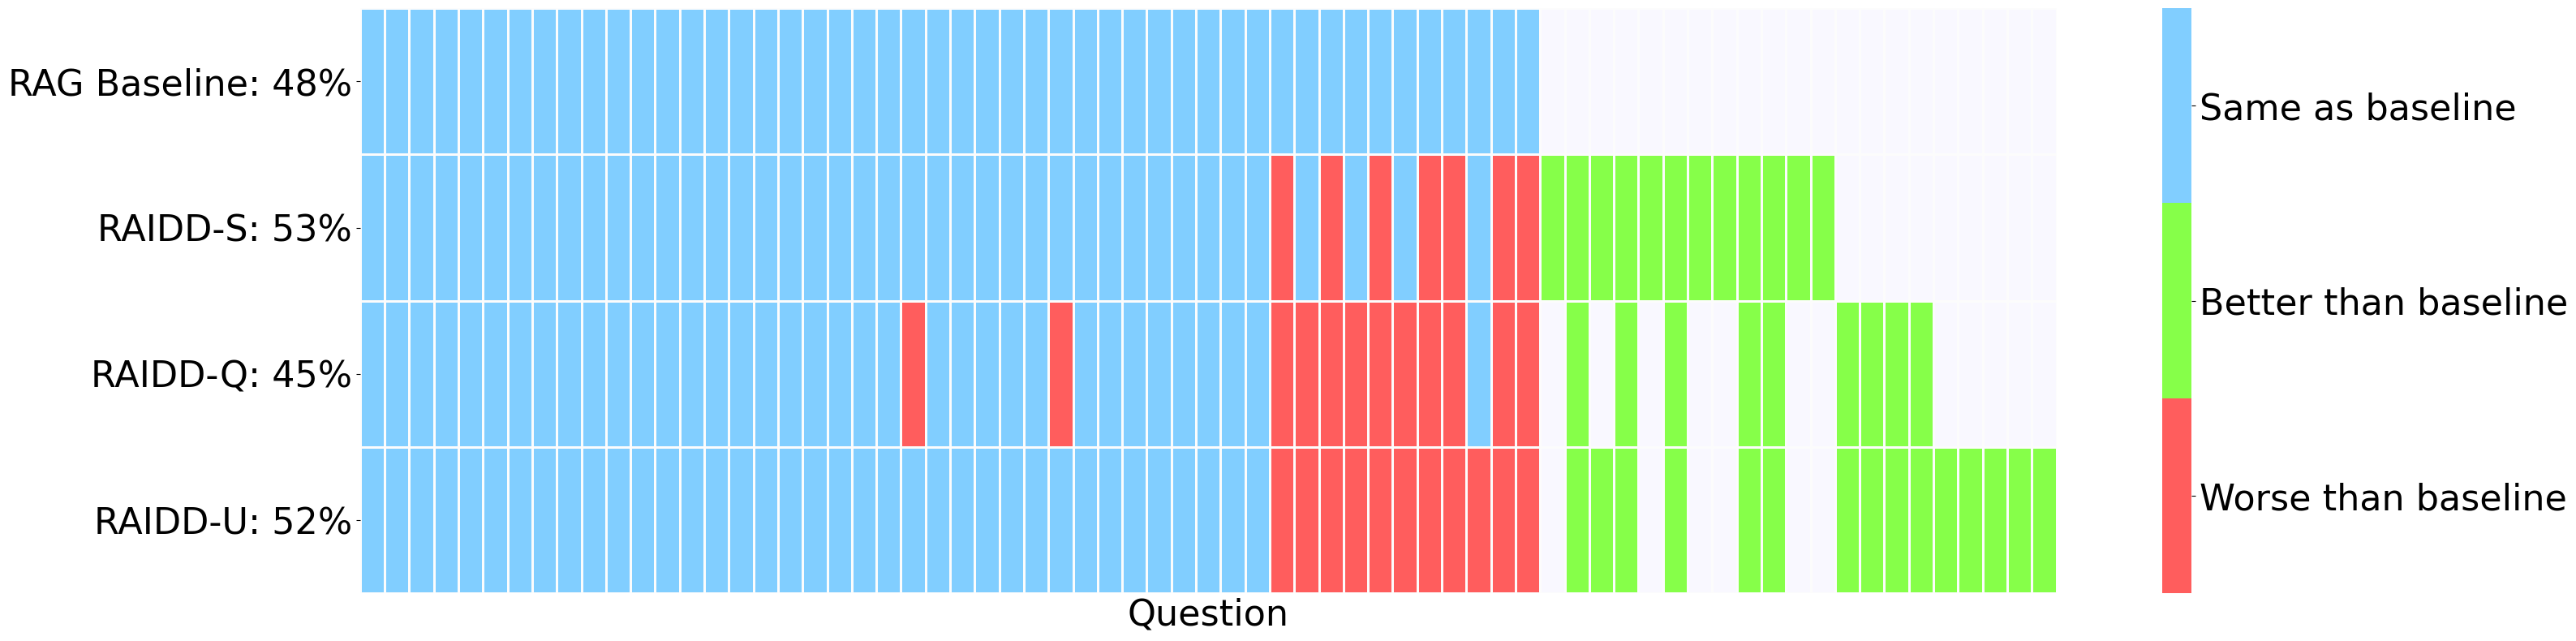

In [50]:
correct_mat = np.array(
    [
        [output["correct"] for output in union_outputs],
        [output["correct"] for output in q_plus_outputs],
        # [output["correct"] for output in question_generation_outputs],
        [output["correct"] for output in s_plus_outputs],
        # [output["correct"] for output in summarization_outputs],
        [output["correct"] for output in baseline_outputs],
    ]
).T


def sort_rows(array):
    # row_sums = array.sum(axis=1)
    # dtype = [("sum", float)] + [("col{}".format(i), array.dtype) for i in range(array.shape[1])]
    # structured_array = np.zeros(array.shape[0], dtype=dtype)
    # structured_array["sum"] = -row_sums
    # for i in range(array.shape[1]):
    #     structured_array["col{}".format(i)] = array[:, i]
    # sorted_indices = np.argsort(structured_array, order=dtype[0][0:1] + tuple(name for name, _ in dtype[1:]))
    # return sorted_indices.tolist()
    order = []
    baseline_correct = [i for i, correct in enumerate(array[:, -1]) if correct]
    order += baseline_correct

    incorrect_4 = [i for i, correct in enumerate(array[:, -4]) if not correct and array[i, -1]]
    for i in incorrect_4:
        if i in order:
            order.remove(i)
    order += incorrect_4

    correct_2 = [i for i, correct in enumerate(array[:, -2]) if correct and i not in order]
    order += correct_2

    correct_3 = [i for i, correct in enumerate(array[:, -3]) if correct and i not in order]
    order += correct_3

    correct_4 = [i for i, correct in enumerate(array[:, -4]) if correct and i not in order]
    order += correct_4

    # correct_5 = [i for i, correct in enumerate(array[:, -5]) if correct and i not in order]
    # order += correct_5

    # correct_6 = [i for i, correct in enumerate(array[:, -6]) if correct and i not in order]
    # order += correct_6

    # incorrect = [i for i in range(array.shape[0]) if i not in order]
    # order += incorrect
    return order


row_order = sort_rows(correct_mat)
correct_mat = correct_mat[row_order]

correct_mat_colorful = np.zeros(correct_mat.shape + (3,))
for question_num in range(correct_mat.shape[0]):
    for model_num in range(correct_mat.shape[1]):
        if correct_mat[question_num, model_num] == correct_mat[question_num, -1]:
            if correct_mat[question_num, model_num] == True:
                correct_mat_colorful[question_num, model_num] = [129 / 255, 206 / 255, 255 / 255]
            else:
                correct_mat_colorful[question_num, model_num] = [249 / 255, 248 / 255, 255 / 255]
        elif correct_mat[question_num, model_num] == True:
            correct_mat_colorful[question_num, model_num] = [134 / 255, 255 / 255, 73 / 255]
        else:
            correct_mat_colorful[question_num, model_num] = [255 / 255, 93 / 255, 93 / 255]

correct_mat_colorful = correct_mat_colorful.transpose((1, 0, 2))

fig, ax = plt.subplots()


# Make the plot wider than the default
fig.set_size_inches(32, 8)
# Make edge colors transparent
ax.pcolormesh(correct_mat_colorful, edgecolors=[252 / 255, 252 / 255, 252 / 255], linewidth=1)
# Set the y ticks
ticks = [
    f"RAIDD-U: {sum(correct_mat[:, 0])}%",
    f"RAIDD-Q: {sum(correct_mat[:, 1])}%",
    f"RAIDD-S: {sum(correct_mat[:, 2])}%",
    f"RAG Baseline: {sum(correct_mat[:, 3])}%",
]
ax.set_yticks(np.arange(0.5, len(ticks), 1), ticks)
plt.yticks(fontsize=32)
ax.set_xticks([], [])
# Remove borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# Add background color to the plot
ax.set_facecolor([0.95, 0, 0.95])
# Set the x and y axis labels
ax.set_xlabel("Question", fontsize=32)


# Add legend
cmap = mcolors.ListedColormap(
    [[255 / 255, 93 / 255, 93 / 255], [134 / 255, 255 / 255, 73 / 255], [129 / 255, 206 / 255, 255 / 255]]
)
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, boundaries=bounds, ticks=[0.5, 1.5, 2.5], spacing="proportional")
cbar.set_ticklabels(["Worse than baseline", "Better than baseline", "Same as baseline"], fontsize=32)
# remove minor ticks
cbar.ax.yaxis.set_tick_params(which="minor", length=0)
# Remove the colorbar border
cbar.outline.set_visible(False)

# Make background transparent
fig.patch.set_alpha(0)

plt.tight_layout()
plt.savefig("figures/confusion_comparison.png")

In [5]:
incorrect_baseline_indices = [i for i, output in enumerate(baseline_outputs) if output["correct"] == False]
correct_summarization_indices = [i for i, output in enumerate(summarization_outputs) if output["correct"] == True]
correct_question_generation_indices = [i for i, output in enumerate(question_generation_outputs) if output["correct"] == True]
correct_union_indices = [i for i, output in enumerate(union_outputs) if output["correct"] == True]

union_advantage_indices = set(correct_summarization_indices) & set(incorrect_baseline_indices)
union_advantage_indices = list(union_advantage_indices)
union_advantage_indices.sort()

In [6]:
def print_multiple_lines(text, width=100):
    lines = textwrap.wrap(text.strip(), width)
    for line in lines:
        print(line)

In [7]:
i = 0
question_index = union_advantage_indices[i]

print("Question:")
print(union_outputs[question_index]["question"])

print("\n")
print("Ground truth:")
print(union_outputs[question_index]["ground_truth"])

print("\n")
print("Baseline answer:")
print_multiple_lines(baseline_outputs[question_index]["generated_answer"])

print("\n")
print("Baseline evidence:")
for evidence in baseline_outputs[question_index]["additional_info"]["top_chunks_text"]:
    print_multiple_lines(evidence)

print("\n")
print("RAIDD answer:")
print_multiple_lines(union_outputs[question_index]["generated_answer"])

print("\n")
print("RAIDD evidence:")
for evidence in union_outputs[question_index]["additional_info"]["top_chunks_info"]:
    print_multiple_lines(evidence["text"])

Question:
How many years did Picardo work for Parador from his first of Parador projects until the bankruptcy on Parador?


Ground truth:
Twenty-nine years.


Baseline answer:
Picardo worked for Parador from the early 1960s to 1985, which is approximately 25 years. However,
the question mentions a bankruptcy on Parador, which is not mentioned in the given context.
Therefore, I cannot provide a precise answer based on the given information.


Baseline evidence:
Despite these further works, the Parador has kept its original character as established by Picardo.
Most of the improvements have been only to modernise the services and facilities. Other Parador
projects. In the 1960s and 1970s Picardo was called upon by the Ministry of Information and Tourism
to investigate and report on a number of other old buildings for possible conversion into Paradores.
He drew up proposals and plans for a number of these buildings but, despite detailed work on some of
them, they did not become Paradores w

In [72]:
from rag_components import *

/Users/isaac/miniforge3/envs/LongRAG/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for bigainlco/LooGLE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bigainlco/LooGLE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def get_rank_of_text(query, text, index_title):
    index = get_index_by_title(index_title)
    sim_score = similarity_score(query, index_id, node_id):

In [69]:
s_plus_score_pairs = [
    [chunk["feature_score"], chunk["text_score"]]
    for output in s_plus_outputs
    for chunk in output["additional_info"]["top_chunks_info"]
]
s_plus_score_pairs = np.array(s_plus_score_pairs)

q_plus_score_pairs = [
    [chunk["feature_score"], chunk["text_score"]]
    for output in q_plus_outputs
    for chunk in output["additional_info"]["top_chunks_info"]
]
q_plus_score_pairs = np.array(q_plus_score_pairs)

u_score_pairs = [
    [chunk["feature_score"], chunk["text_score"]]
    for output in union_outputs
    for chunk in output["additional_info"]["top_chunks_info"]
]
u_score_pairs = np.array(u_score_pairs)

s_plus_mean_diff = np.mean(s_plus_score_pairs[:, 0] - s_plus_score_pairs[:, 1])

q_plus_mean_diff = np.mean(q_plus_score_pairs[:, 0] - q_plus_score_pairs[:, 1])

u_mean_diff = np.mean(u_score_pairs[:, 0] - u_score_pairs[:, 1])

print(f"Mean difference between feature and text scores for S+: {s_plus_mean_diff}")
print(f"Mean difference between feature and text scores for Q+: {q_plus_mean_diff}")
print(f"Mean difference between feature and text scores for U: {u_mean_diff}")

Mean difference between feature and text scores for S+: 0.02118893233065103
Mean difference between feature and text scores for Q+: 0.04050869711816611
Mean difference between feature and text scores for U: 0.043610698547539906
